<a href="https://colab.research.google.com/github/luciainnocenti/Homework3-PACS/blob/master/MLDL_Homework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms

from PIL import Image
from tqdm import tqdm


from numpy import random 
import numpy as np

random.seed(33)

#**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

BATCH_SIZE = 128     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 20      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [0]:
#V1

alfa = 1
LR = 1e-4

In [0]:
#V2

alfa = 1
LR = 1e-5

In [0]:
#V3

alfa = 0.1
LR = 1e-5

In [0]:
#V4, version with variable alfa

alfa = 0
LR = 1e-5
NUM_EPOCHS = 20
p = 0

# Import and definition

In [0]:
# Clone github repository with data
!git clone https://github.com/luciainnocenti/Homework3-PACS.git
!mv 'Homework3-PACS' 'HW_PACS'

from HW_PACS.dataset import PACS_Dataset 

Cloning into 'Homework3-PACS'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 10123 (delta 11), reused 0 (delta 0), pack-reused 10102
Receiving objects: 100% (10123/10123), 174.25 MiB | 29.87 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Checking out files: 100% (9995/9995), done.


In [4]:
## Define transforms for training phase
#transformer = transforms.Compose([transforms.Resize(256),   
#                                      transforms.CenterCrop(224),
#                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
#])
#rootPhoto = "HW_PACS/PACS/photo"
#photos = PACS_Dataset(root = rootPhoto, transform = transformer)
#
#rootArt_painting = "HW_PACS/PACS/art_painting"
#art_painting = PACS_Dataset(root = rootArt_painting, transform = transformer)
#
#photos_dataloader = DataLoader(photos, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
#art_painting_dataloader = DataLoader(art_painting, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
#
#print(photos.meanAndStd(photos_dataloader))
#print(art_painting.meanAndStd(art_painting_dataloader))

(tensor([0.5088, 0.4744, 0.4307]), tensor([0.2725, 0.2620, 0.2774]))
(tensor([0.5530, 0.5018, 0.4488]), tensor([0.2750, 0.2648, 0.2775]))


#**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),   
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
                                      transforms.Normalize((0.5088, 0.4744, 0.4307), (0.2725, 0.2620, 0.2774)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the test phase
test_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5530, 0.5018, 0.4488), (0.2750, 0.2648, 0.2775))                                    
])

#**Prepare Dataset**

In [0]:
rootPhoto = "HW_PACS/PACS/photo"
photos = PACS_Dataset(root = rootPhoto, transform = train_transform)

rootArt_painting = "HW_PACS/PACS/art_painting"
art_painting = PACS_Dataset(root = rootArt_painting, transform = test_transform)

# Check dataset sizes
print('Train Dataset: {}'.format(len(photos)))
print('Test Dataset: {}'.format(len(art_painting)))

#**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
photos_dataloader = DataLoader(photos, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
art_painting_dataloader = DataLoader(art_painting, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

#**Model without DANN**

##**Prepare Network**

In [0]:
from HW_PACS.gradient_reversal_example import alexNetDA 

net = alexNetDA(num_classes = 7)


##**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() 

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum

#optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

optimizer = optim.Adam(parameters_to_optimize, LR)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [10]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark # Calling this optimizes runtime
running_corrects = 0
current_step = 0
# Start iterating over the epochs
# Iterate over the dataset
losses = []
accuracies = []
for epoch in range(NUM_EPOCHS):
  scheduler.step() 
  
  for images, labels in  tqdm(photos_dataloader):

    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights

    loss.backward()  # backward pass: computes gradients

    optimizer.step() # update weights based on accumulated gradients

    current_step += 1
    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()
    #losses.append(loss.item())

  # Calculate Accuracy
  accuracy = running_corrects / float(len(photos))
  accuracies.append(accuracy)
  print("Accuracy on training set = "  + str(accuracy))
  running_corrects = 0
    

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/14 [00:00<?, ?it/s]

Step 0, Loss 2.254960775375366


 79%|███████▊  | 11/14 [00:07<00:01,  1.96it/s]

Step 10, Loss 1.489620566368103


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.3059880239520958


 50%|█████     | 7/14 [00:05<00:05,  1.33it/s]

Step 20, Loss 0.9450950622558594


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.7395209580838323


 21%|██▏       | 3/14 [00:03<00:16,  1.48s/it]

Step 30, Loss 0.6111786365509033


 93%|█████████▎| 13/14 [00:08<00:00,  2.53it/s]

Step 40, Loss 0.36406636238098145


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.8658682634730539


 64%|██████▍   | 9/14 [00:07<00:03,  1.26it/s]

Step 50, Loss 0.3085598349571228


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9029940119760479


 36%|███▌      | 5/14 [00:04<00:10,  1.20s/it]

Step 60, Loss 0.2771582305431366


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9287425149700599


  7%|▋         | 1/14 [00:02<00:37,  2.85s/it]

Step 70, Loss 0.12375209480524063


 79%|███████▊  | 11/14 [00:07<00:01,  1.91it/s]

Step 80, Loss 0.124554842710495


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.948502994011976


 50%|█████     | 7/14 [00:05<00:05,  1.39it/s]

Step 90, Loss 0.12414410710334778


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9562874251497006


 21%|██▏       | 3/14 [00:03<00:16,  1.53s/it]

Step 100, Loss 0.14980605244636536


 93%|█████████▎| 13/14 [00:08<00:00,  2.53it/s]

Step 110, Loss 0.07450693845748901


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9634730538922156


 64%|██████▍   | 9/14 [00:07<00:04,  1.22it/s]

Step 120, Loss 0.09483383595943451


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9772455089820359


 36%|███▌      | 5/14 [00:04<00:10,  1.18s/it]

Step 130, Loss 0.05298248305916786


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.981437125748503


  7%|▋         | 1/14 [00:02<00:35,  2.74s/it]

Step 140, Loss 0.07883493602275848


 79%|███████▊  | 11/14 [00:07<00:01,  1.94it/s]

Step 150, Loss 0.05110318958759308


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9802395209580839


 50%|█████     | 7/14 [00:05<00:05,  1.30it/s]

Step 160, Loss 0.022373275831341743


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9880239520958084


 21%|██▏       | 3/14 [00:03<00:16,  1.49s/it]

Step 170, Loss 0.04926039278507233


 93%|█████████▎| 13/14 [00:08<00:00,  2.61it/s]

Step 180, Loss 0.06816151738166809


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9832335329341317


 64%|██████▍   | 9/14 [00:07<00:04,  1.24it/s]

Step 190, Loss 0.02939813956618309


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9892215568862276


 36%|███▌      | 5/14 [00:04<00:10,  1.17s/it]

Step 200, Loss 0.027563879266381264


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9946107784431137


  7%|▋         | 1/14 [00:02<00:35,  2.72s/it]

Step 210, Loss 0.02025092951953411


 79%|███████▊  | 11/14 [00:07<00:01,  1.89it/s]

Step 220, Loss 0.03401202708482742


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9916167664670659


 50%|█████     | 7/14 [00:05<00:05,  1.36it/s]

Step 230, Loss 0.012182516977190971


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9934131736526947


 21%|██▏       | 3/14 [00:03<00:15,  1.40s/it]

Step 240, Loss 0.019735146313905716


 93%|█████████▎| 13/14 [00:08<00:00,  2.39it/s]

Step 250, Loss 0.030757606029510498


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9946107784431137


 64%|██████▍   | 9/14 [00:07<00:04,  1.24it/s]

Step 260, Loss 0.033035457134246826


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9946107784431137


 36%|███▌      | 5/14 [00:04<00:10,  1.20s/it]

Step 270, Loss 0.01758503168821335


100%|██████████| 14/14 [00:08<00:00,  1.68it/s]

Accuracy on training set = 0.9976047904191617


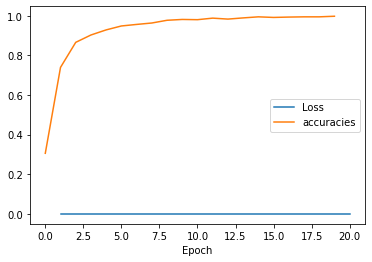

In [11]:
import numpy as np
import matplotlib.pyplot as plt

X = np.zeros(NUM_EPOCHS)
n = 0
cnt = 0
for l in losses:
  X[n] += l
  cnt += 1
  if( cnt == 14):
    X[n] = X[n] / 14
    n += 1
    cnt = 0
  
x_epochs = np.linspace(1,NUM_EPOCHS,NUM_EPOCHS)

plt.plot(x_epochs, X , accuracies, '-')
plt.xlabel("Epoch")
plt.legend(['Loss', 'accuracies'])

plt.show()

##**Test**

In [12]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode
losses = []
running_corrects = 0
for images, labels in tqdm(art_painting_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  loss = criterion(outputs, labels)
  losses.append(loss)
  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(art_painting))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 16/16 [00:09<00:00,  1.75it/s]

Test Accuracy: 0.46240234375


In [0]:
batches = np.linspace(0, 15, 16)
plt.plot(batches, losses, '-')
plt.xlabel("Epoch")
plt.legend(['Loss'])


In [13]:
loss.item()

5.761810779571533

# Model with DANN

## Network

In [0]:
net = alexNetDA(num_classes = 7)
net = net.to(DEVICE)

## Loss, Optim and Scheduler

In [0]:
criterion_class = nn.CrossEntropyLoss() 
criterion_domain = nn.CrossEntropyLoss()

parameters_to_optimize = net.parameters() 

#optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
optimizer = optim.Adam(parameters_to_optimize, LR)


scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

## Test function

In [0]:
def testFunction(datasetName, epoch):  
  net = torch.load('model_epoch_' + str(epoch) + '.pt')
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode
  if (datasetName == 'photo'):
    dataLoader = DataLoader(photos, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
  elif( datasetName == 'artPainting'):
    dataLoader = DataLoader(art_painting, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

  lenLoader = len(dataLoader)
  iterator = iter(dataLoader)
  totalLen = 0
  running_corrects = 0
  criterion = nn.CrossEntropyLoss() 
  for i in range(lenLoader):
    t_img, t_label = next(iterator)

    t_img = t_img.to(DEVICE)
    t_label = t_label.to(DEVICE)

    # Forward Pass
    classes_output = net(t_img)

    loss = criterion(classes_output, t_label)

    # Get predictions
    _, preds = torch.max(classes_output.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == t_label.data).data.item()
    totalLen += len(t_img)

  # Calculate Accuracy
  accuracy = running_corrects / float(totalLen)

  print(f'Accuracy on  {datasetName}' f' during epoch {epoch}' f' is {accuracy}' f' loss is {loss}')

## Train 

In [0]:
#photos_dataloader = DataLoader(photos, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
#art_painting_dataloader = DataLoader(art_painting, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

max_batches = max(len(photos_dataloader), len(art_painting_dataloader))
min_batches = min(len(photos_dataloader), len(art_painting_dataloader))

In [0]:
import matplotlib.pyplot as plt

def plotfunction(losses):
  losses_s_label = []
  losses_s_domain = []
  losses_t_domain = []

  for el in losses:
    losses_s_label.append(el[0])
    losses_s_domain.append(el[1])
    losses_t_domain.append(el[2])

  plt.plot(np.linspace(0,max_batches-1, max_batches), losses_s_label)
  plt.plot(np.linspace(0,max_batches-1, max_batches), losses_s_domain)
  plt.plot(np.linspace(0,max_batches-1, max_batches), losses_t_domain)   
  plt.xlabel("Epoch")
  plt.legend(['losses_s_label', 'losses_s_domain', 'losses_t_domain'])
  plt.show()

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1/16] class_loss: 2.1714 s_domain_loss: 0.6670 t_domain_loss: 0.7787 aplha: 0.0
[2/16] class_loss: 2.0603 s_domain_loss: 0.6658 t_domain_loss: 0.7535 aplha: 0.015623728558408878
[3/16] class_loss: 2.0022 s_domain_loss: 0.6789 t_domain_loss: 0.7455 aplha: 0.031239831446031152
[4/16] class_loss: 1.8817 s_domain_loss: 0.6906 t_domain_loss: 0.7465 aplha: 0.04684069787264811
[5/16] class_loss: 1.8576 s_domain_loss: 0.6920 t_domain_loss: 0.7353 aplha: 0.06241874674751258
[6/16] class_loss: 1.7827 s_domain_loss: 0.6968 t_domain_loss: 0.7180 aplha: 0.07796644137536823
[7/16] class_loss: 1.5899 s_domain_loss: 0.7095 t_domain_loss: 0.7153 aplha: 0.09347630396922768
[8/16] class_loss: 1.6305 s_domain_loss: 0.7044 t_domain_loss: 0.7141 aplha: 0.10894092992085458
[9/16] class_loss: 1.5436 s_domain_loss: 0.7131 t_domain_loss: 0.7170 aplha: 0.12435300177159614
[10/16] class_loss: 1.4883 s_domain_loss: 0.6956 t_domain_loss: 0.7024 aplha: 0.13970530282831417
[11/16] class_loss: 1.4462 s_domain_loss: 0

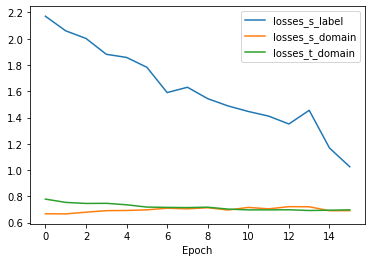

[1/16] class_loss: 1.0104 s_domain_loss: 0.6840 t_domain_loss: 0.6776 aplha: 0.2449186624037092
[2/16] class_loss: 1.1342 s_domain_loss: 0.6784 t_domain_loss: 0.6688 aplha: 0.25954921480882676
[3/16] class_loss: 1.0324 s_domain_loss: 0.6803 t_domain_loss: 0.6794 aplha: 0.27406158896076627
[4/16] class_loss: 0.9792 s_domain_loss: 0.6732 t_domain_loss: 0.6847 aplha: 0.2884502129727393
[5/16] class_loss: 0.8809 s_domain_loss: 0.6775 t_domain_loss: 0.6901 aplha: 0.3027097293321084
[6/16] class_loss: 0.7845 s_domain_loss: 0.6676 t_domain_loss: 0.6903 aplha: 0.31683500112336604
[7/16] class_loss: 0.7673 s_domain_loss: 0.6575 t_domain_loss: 0.6934 aplha: 0.33082111749362797
[8/16] class_loss: 0.7314 s_domain_loss: 0.6637 t_domain_loss: 0.6944 aplha: 0.34466339835857207
[9/16] class_loss: 0.8202 s_domain_loss: 0.6660 t_domain_loss: 0.7001 aplha: 0.35835739835078595
[10/16] class_loss: 0.7314 s_domain_loss: 0.6580 t_domain_loss: 0.6961 aplha: 0.371898910016385
[11/16] class_loss: 0.7177 s_domai

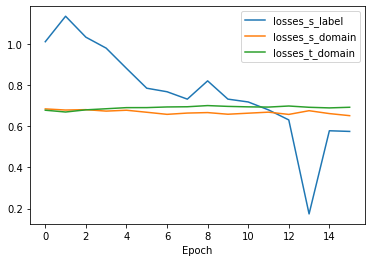

[1/16] class_loss: 0.6983 s_domain_loss: 0.6577 t_domain_loss: 0.6738 aplha: 0.4621171572600098
[2/16] class_loss: 0.4891 s_domain_loss: 0.6456 t_domain_loss: 0.6615 aplha: 0.4743163252573668
[3/16] class_loss: 0.4845 s_domain_loss: 0.6530 t_domain_loss: 0.6707 aplha: 0.4863360172249622
[4/16] class_loss: 0.4996 s_domain_loss: 0.6500 t_domain_loss: 0.6735 aplha: 0.49817442622945496
[5/16] class_loss: 0.4359 s_domain_loss: 0.6453 t_domain_loss: 0.6777 aplha: 0.5098299737352565
[6/16] class_loss: 0.4118 s_domain_loss: 0.6486 t_domain_loss: 0.6765 aplha: 0.5213013053545767
[7/16] class_loss: 0.3875 s_domain_loss: 0.6433 t_domain_loss: 0.6767 aplha: 0.5325872861719194
[8/16] class_loss: 0.4983 s_domain_loss: 0.6446 t_domain_loss: 0.6709 aplha: 0.5436869956781494
[9/16] class_loss: 0.3378 s_domain_loss: 0.6456 t_domain_loss: 0.6778 aplha: 0.5545997223493822
[10/16] class_loss: 0.4074 s_domain_loss: 0.6423 t_domain_loss: 0.6716 aplha: 0.5653249579058752
[11/16] class_loss: 0.3806 s_domain_lo

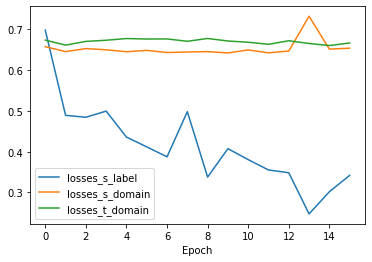

[1/16] class_loss: 0.2740 s_domain_loss: 0.6372 t_domain_loss: 0.6539 aplha: 0.6351489523872873
[2/16] class_loss: 0.3378 s_domain_loss: 0.6360 t_domain_loss: 0.6405 aplha: 0.6443782610439006
[3/16] class_loss: 0.2830 s_domain_loss: 0.6204 t_domain_loss: 0.6505 aplha: 0.6534235881413468
[4/16] class_loss: 0.3081 s_domain_loss: 0.6317 t_domain_loss: 0.6538 aplha: 0.6622860957166337
[5/16] class_loss: 0.2356 s_domain_loss: 0.6399 t_domain_loss: 0.6569 aplha: 0.6709670742068738
[6/16] class_loss: 0.2285 s_domain_loss: 0.6301 t_domain_loss: 0.6590 aplha: 0.6794679353444786
[7/16] class_loss: 0.2458 s_domain_loss: 0.6280 t_domain_loss: 0.6595 aplha: 0.6877902051090852
[8/16] class_loss: 0.2457 s_domain_loss: 0.6373 t_domain_loss: 0.6501 aplha: 0.6959355167556514
[9/16] class_loss: 0.3239 s_domain_loss: 0.6299 t_domain_loss: 0.6606 aplha: 0.7039056039366212
[10/16] class_loss: 0.2974 s_domain_loss: 0.6319 t_domain_loss: 0.6534 aplha: 0.7117022939345188
[11/16] class_loss: 0.2082 s_domain_los

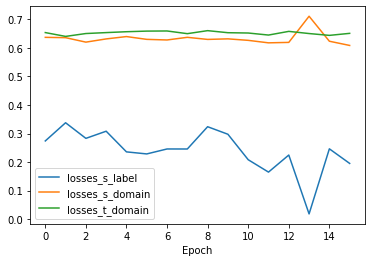

[1/16] class_loss: 0.2512 s_domain_loss: 0.6306 t_domain_loss: 0.6394 aplha: 0.7615941559557646
[2/16] class_loss: 0.1634 s_domain_loss: 0.6147 t_domain_loss: 0.6254 aplha: 0.7680785634920664
[3/16] class_loss: 0.1967 s_domain_loss: 0.6241 t_domain_loss: 0.6338 aplha: 0.7744091874342136
[4/16] class_loss: 0.2770 s_domain_loss: 0.6204 t_domain_loss: 0.6374 aplha: 0.7805884522440583
[5/16] class_loss: 0.2470 s_domain_loss: 0.6044 t_domain_loss: 0.6390 aplha: 0.7866188121086974
[6/16] class_loss: 0.1509 s_domain_loss: 0.6044 t_domain_loss: 0.6418 aplha: 0.7925027462672405
[7/16] class_loss: 0.1693 s_domain_loss: 0.6133 t_domain_loss: 0.6417 aplha: 0.7982427545398871
[8/16] class_loss: 0.1415 s_domain_loss: 0.6101 t_domain_loss: 0.6304 aplha: 0.80384135305908
[9/16] class_loss: 0.2269 s_domain_loss: 0.6230 t_domain_loss: 0.6416 aplha: 0.8093010702017811
[10/16] class_loss: 0.2193 s_domain_loss: 0.6030 t_domain_loss: 0.6333 aplha: 0.8146244427212481
[11/16] class_loss: 0.2031 s_domain_loss:

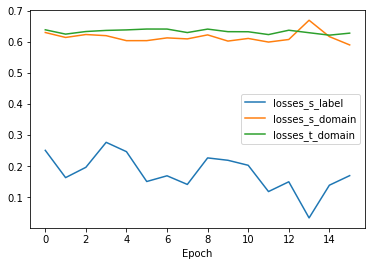

[1/16] class_loss: 0.1679 s_domain_loss: 0.5897 t_domain_loss: 0.6185 aplha: 0.8482836399575131
[2/16] class_loss: 0.1067 s_domain_loss: 0.6085 t_domain_loss: 0.6042 aplha: 0.852607460587903
[3/16] class_loss: 0.1387 s_domain_loss: 0.6354 t_domain_loss: 0.6109 aplha: 0.8568176011108952
[4/16] class_loss: 0.1142 s_domain_loss: 0.6087 t_domain_loss: 0.6137 aplha: 0.8609165109883439
[5/16] class_loss: 0.1484 s_domain_loss: 0.5809 t_domain_loss: 0.6160 aplha: 0.8649066177207418
[6/16] class_loss: 0.2072 s_domain_loss: 0.5945 t_domain_loss: 0.6192 aplha: 0.8687903250818612
[7/16] class_loss: 0.1972 s_domain_loss: 0.5901 t_domain_loss: 0.6187 aplha: 0.8725700114960693
[8/16] class_loss: 0.2014 s_domain_loss: 0.5940 t_domain_loss: 0.6073 aplha: 0.8762480285527146
[9/16] class_loss: 0.1080 s_domain_loss: 0.5988 t_domain_loss: 0.6191 aplha: 0.8798266996519848
[10/16] class_loss: 0.1656 s_domain_loss: 0.5879 t_domain_loss: 0.6117 aplha: 0.883308318776638
[11/16] class_loss: 0.1175 s_domain_loss:

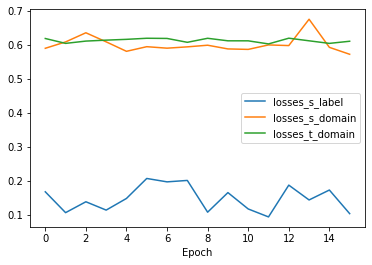

[1/16] class_loss: 0.1359 s_domain_loss: 0.5776 t_domain_loss: 0.6032 aplha: 0.9051482536448667
[2/16] class_loss: 0.1470 s_domain_loss: 0.5626 t_domain_loss: 0.5901 aplha: 0.9079321952015194
[3/16] class_loss: 0.1190 s_domain_loss: 0.5811 t_domain_loss: 0.5966 aplha: 0.9106382594546996
[4/16] class_loss: 0.1579 s_domain_loss: 0.5639 t_domain_loss: 0.5978 aplha: 0.9132684024721864
[5/16] class_loss: 0.0771 s_domain_loss: 0.5910 t_domain_loss: 0.5987 aplha: 0.9158245441687622
[6/16] class_loss: 0.0908 s_domain_loss: 0.5537 t_domain_loss: 0.6014 aplha: 0.9183085681801013
[7/16] class_loss: 0.1384 s_domain_loss: 0.5979 t_domain_loss: 0.6005 aplha: 0.92072232179806
[8/16] class_loss: 0.0898 s_domain_loss: 0.5958 t_domain_loss: 0.5896 aplha: 0.9230676159633513
[9/16] class_loss: 0.1135 s_domain_loss: 0.5751 t_domain_loss: 0.6022 aplha: 0.9253462253117413
[10/16] class_loss: 0.1588 s_domain_loss: 0.5785 t_domain_loss: 0.5938 aplha: 0.9275598882700506
[11/16] class_loss: 0.0850 s_domain_loss:

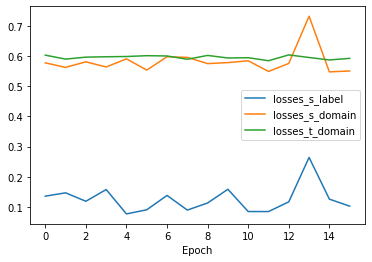

[1/16] class_loss: 0.0760 s_domain_loss: 0.5740 t_domain_loss: 0.5868 aplha: 0.9413755384972873
[2/16] class_loss: 0.0697 s_domain_loss: 0.5636 t_domain_loss: 0.5734 aplha: 0.9431279339102947
[3/16] class_loss: 0.1183 s_domain_loss: 0.5455 t_domain_loss: 0.5811 aplha: 0.9448294355464197
[4/16] class_loss: 0.1186 s_domain_loss: 0.5695 t_domain_loss: 0.5803 aplha: 0.9464814336291136
[5/16] class_loss: 0.1139 s_domain_loss: 0.5598 t_domain_loss: 0.5813 aplha: 0.9480852856044062
[6/16] class_loss: 0.0895 s_domain_loss: 0.5529 t_domain_loss: 0.5833 aplha: 0.9496423165987962
[7/16] class_loss: 0.1223 s_domain_loss: 0.5417 t_domain_loss: 0.5823 aplha: 0.9511538198917857
[8/16] class_loss: 0.0997 s_domain_loss: 0.5717 t_domain_loss: 0.5707 aplha: 0.9526210574012512
[9/16] class_loss: 0.0712 s_domain_loss: 0.5441 t_domain_loss: 0.5830 aplha: 0.9540452601799487
[10/16] class_loss: 0.1127 s_domain_loss: 0.5569 t_domain_loss: 0.5733 aplha: 0.9554276289215491
[11/16] class_loss: 0.1331 s_domain_los

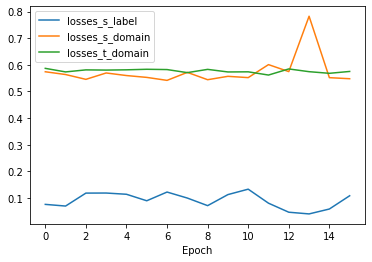

[1/16] class_loss: 0.0674 s_domain_loss: 0.5253 t_domain_loss: 0.5727 aplha: 0.9640275800758169
[2/16] class_loss: 0.0944 s_domain_loss: 0.5676 t_domain_loss: 0.5612 aplha: 0.9651150305275895
[3/16] class_loss: 0.1067 s_domain_loss: 0.5457 t_domain_loss: 0.5698 aplha: 0.9661701734665469
[4/16] class_loss: 0.0834 s_domain_loss: 0.5243 t_domain_loss: 0.5701 aplha: 0.9671939349676739
[5/16] class_loss: 0.1539 s_domain_loss: 0.5628 t_domain_loss: 0.5723 aplha: 0.9681872165763705
[6/16] class_loss: 0.0808 s_domain_loss: 0.5205 t_domain_loss: 0.5764 aplha: 0.9691508958363175
[7/16] class_loss: 0.0888 s_domain_loss: 0.5450 t_domain_loss: 0.5754 aplha: 0.9700858268137
[8/16] class_loss: 0.0843 s_domain_loss: 0.5356 t_domain_loss: 0.5642 aplha: 0.9709928406172359
[9/16] class_loss: 0.0330 s_domain_loss: 0.4962 t_domain_loss: 0.5775 aplha: 0.9718727459135088
[10/16] class_loss: 0.0503 s_domain_loss: 0.5130 t_domain_loss: 0.5664 aplha: 0.9727263294371402
[11/16] class_loss: 0.1014 s_domain_loss: 

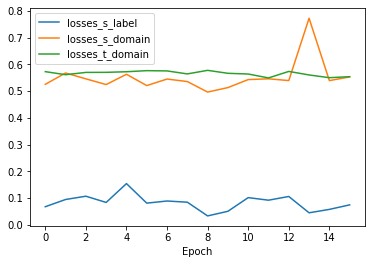

[1/16] class_loss: 0.0528 s_domain_loss: 0.5110 t_domain_loss: 0.5517 aplha: 0.9780261147388136
[2/16] class_loss: 0.0552 s_domain_loss: 0.5237 t_domain_loss: 0.5388 aplha: 0.9786949783205476
[3/16] class_loss: 0.0921 s_domain_loss: 0.5423 t_domain_loss: 0.5449 aplha: 0.9793436949613898
[4/16] class_loss: 0.0859 s_domain_loss: 0.5232 t_domain_loss: 0.5427 aplha: 0.9799728587536536
[5/16] class_loss: 0.1056 s_domain_loss: 0.5524 t_domain_loss: 0.5441 aplha: 0.9805830470370518
[6/16] class_loss: 0.1131 s_domain_loss: 0.5372 t_domain_loss: 0.5475 aplha: 0.9811748208247801
[7/16] class_loss: 0.0501 s_domain_loss: 0.5123 t_domain_loss: 0.5476 aplha: 0.9817487252216388
[8/16] class_loss: 0.0463 s_domain_loss: 0.5081 t_domain_loss: 0.5380 aplha: 0.9823052898341393
[9/16] class_loss: 0.0932 s_domain_loss: 0.5445 t_domain_loss: 0.5516 aplha: 0.9828450291725761
[10/16] class_loss: 0.0729 s_domain_loss: 0.5142 t_domain_loss: 0.5418 aplha: 0.9833684430450518
[11/16] class_loss: 0.1050 s_domain_los

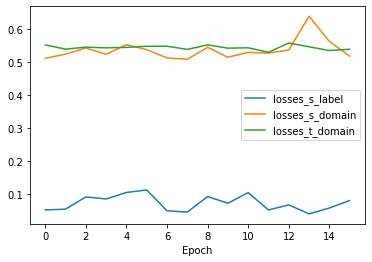

[1/16] class_loss: 0.0409 s_domain_loss: 0.5483 t_domain_loss: 0.5383 aplha: 0.9866142981514305
[2/16] class_loss: 0.0698 s_domain_loss: 0.5319 t_domain_loss: 0.5270 aplha: 0.9870234608066868
[3/16] class_loss: 0.0773 s_domain_loss: 0.4994 t_domain_loss: 0.5344 aplha: 0.987420195726215
[4/16] class_loss: 0.0558 s_domain_loss: 0.5194 t_domain_loss: 0.5317 aplha: 0.9878048756148494
[5/16] class_loss: 0.0647 s_domain_loss: 0.5213 t_domain_loss: 0.5348 aplha: 0.9881778622875124
[6/16] class_loss: 0.0479 s_domain_loss: 0.4875 t_domain_loss: 0.5385 aplha: 0.988539506970016
[7/16] class_loss: 0.0545 s_domain_loss: 0.5058 t_domain_loss: 0.5387 aplha: 0.988890150592618
[8/16] class_loss: 0.0573 s_domain_loss: 0.5034 t_domain_loss: 0.5280 aplha: 0.9892301240764443
[9/16] class_loss: 0.0547 s_domain_loss: 0.5109 t_domain_loss: 0.5423 aplha: 0.9895597486128833
[10/16] class_loss: 0.0802 s_domain_loss: 0.4727 t_domain_loss: 0.5312 aplha: 0.9898793359360678
[11/16] class_loss: 0.0574 s_domain_loss: 

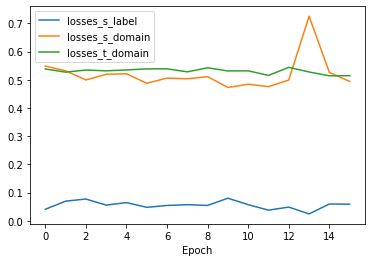

[1/16] class_loss: 0.0408 s_domain_loss: 0.5200 t_domain_loss: 0.5133 aplha: 0.9918597245682079
[2/16] class_loss: 0.0453 s_domain_loss: 0.5166 t_domain_loss: 0.5000 aplha: 0.9921091863867961
[3/16] class_loss: 0.0400 s_domain_loss: 0.4879 t_domain_loss: 0.5059 aplha: 0.9923510327107254
[4/16] class_loss: 0.0381 s_domain_loss: 0.4946 t_domain_loss: 0.5004 aplha: 0.9925854942512276
[5/16] class_loss: 0.0529 s_domain_loss: 0.4983 t_domain_loss: 0.5027 aplha: 0.9928127948371597
[6/16] class_loss: 0.0479 s_domain_loss: 0.5766 t_domain_loss: 0.5057 aplha: 0.9930331516138384
[7/16] class_loss: 0.0426 s_domain_loss: 0.4991 t_domain_loss: 0.5063 aplha: 0.9932467752365213
[8/16] class_loss: 0.0514 s_domain_loss: 0.4894 t_domain_loss: 0.4979 aplha: 0.9934538700586568
[9/16] class_loss: 0.0504 s_domain_loss: 0.5329 t_domain_loss: 0.5150 aplha: 0.9936546343150297
[10/16] class_loss: 0.0528 s_domain_loss: 0.4797 t_domain_loss: 0.5059 aplha: 0.9938492602999036
[11/16] class_loss: 0.0507 s_domain_los

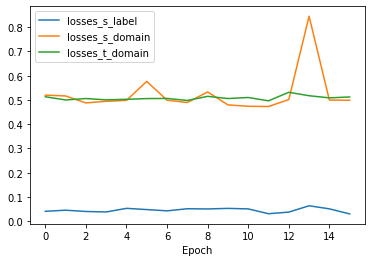

[1/16] class_loss: 0.0303 s_domain_loss: 0.4555 t_domain_loss: 0.5181 aplha: 0.9950547536867307
[2/16] class_loss: 0.0276 s_domain_loss: 0.4445 t_domain_loss: 0.5061 aplha: 0.9952065382597419
[3/16] class_loss: 0.0561 s_domain_loss: 0.4811 t_domain_loss: 0.5125 aplha: 0.9953536749547376
[4/16] class_loss: 0.0575 s_domain_loss: 0.4781 t_domain_loss: 0.5054 aplha: 0.995496305440994
[5/16] class_loss: 0.0639 s_domain_loss: 0.4723 t_domain_loss: 0.5077 aplha: 0.9956345671093094
[6/16] class_loss: 0.0326 s_domain_loss: 0.4711 t_domain_loss: 0.5093 aplha: 0.9957685931988136
[7/16] class_loss: 0.0305 s_domain_loss: 0.4736 t_domain_loss: 0.5068 aplha: 0.9958985129201652
[8/16] class_loss: 0.0433 s_domain_loss: 0.4700 t_domain_loss: 0.4953 aplha: 0.9960244515752319
[9/16] class_loss: 0.0177 s_domain_loss: 0.4665 t_domain_loss: 0.5101 aplha: 0.996146530673345
[10/16] class_loss: 0.0444 s_domain_loss: 0.4879 t_domain_loss: 0.4960 aplha: 0.9962648680442134
[11/16] class_loss: 0.0656 s_domain_loss:

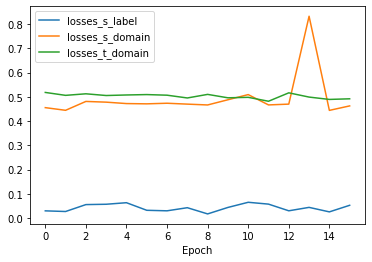

[1/16] class_loss: 0.0382 s_domain_loss: 0.4631 t_domain_loss: 0.4954 aplha: 0.996997635486526
[2/16] class_loss: 0.0380 s_domain_loss: 0.4863 t_domain_loss: 0.4834 aplha: 0.9970898741229344
[3/16] class_loss: 0.0469 s_domain_loss: 0.4309 t_domain_loss: 0.4907 aplha: 0.9971792830067638
[4/16] class_loss: 0.0356 s_domain_loss: 0.4584 t_domain_loss: 0.4829 aplha: 0.9972659487086875
[5/16] class_loss: 0.0420 s_domain_loss: 0.4529 t_domain_loss: 0.4858 aplha: 0.9973499551655736
[6/16] class_loss: 0.0331 s_domain_loss: 0.4796 t_domain_loss: 0.4877 aplha: 0.9974313837597322
[7/16] class_loss: 0.0336 s_domain_loss: 0.4789 t_domain_loss: 0.4870 aplha: 0.9975103133958232
[8/16] class_loss: 0.0608 s_domain_loss: 0.4483 t_domain_loss: 0.4769 aplha: 0.9975868205755074
[9/16] class_loss: 0.0442 s_domain_loss: 0.4611 t_domain_loss: 0.4932 aplha: 0.997660979469889
[10/16] class_loss: 0.0297 s_domain_loss: 0.4549 t_domain_loss: 0.4800 aplha: 0.9977328619898251
[11/16] class_loss: 0.0183 s_domain_loss:

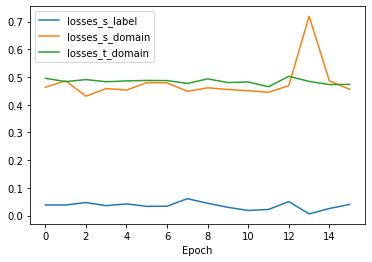

[1/16] class_loss: 0.0396 s_domain_loss: 0.4481 t_domain_loss: 0.4794 aplha: 0.9981778976111988
[2/16] class_loss: 0.0477 s_domain_loss: 0.4767 t_domain_loss: 0.4669 aplha: 0.9982339083044309
[3/16] class_loss: 0.0275 s_domain_loss: 0.4572 t_domain_loss: 0.4733 aplha: 0.9982881987265098
[4/16] class_loss: 0.0315 s_domain_loss: 0.4784 t_domain_loss: 0.4637 aplha: 0.9983408216232819
[5/16] class_loss: 0.0283 s_domain_loss: 0.4624 t_domain_loss: 0.4677 aplha: 0.9983918281287416
[6/16] class_loss: 0.0254 s_domain_loss: 0.4396 t_domain_loss: 0.4711 aplha: 0.9984412678139583
[7/16] class_loss: 0.0231 s_domain_loss: 0.4376 t_domain_loss: 0.4706 aplha: 0.9984891887345411
[8/16] class_loss: 0.0275 s_domain_loss: 0.4731 t_domain_loss: 0.4600 aplha: 0.9985356374766783
[9/16] class_loss: 0.0307 s_domain_loss: 0.4385 t_domain_loss: 0.4775 aplha: 0.998580659201799
[10/16] class_loss: 0.0373 s_domain_loss: 0.4236 t_domain_loss: 0.4639 aplha: 0.9986242976898896
[11/16] class_loss: 0.0446 s_domain_loss

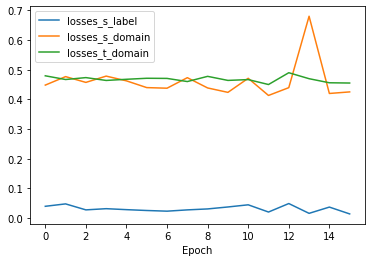

[1/16] class_loss: 0.0291 s_domain_loss: 0.4610 t_domain_loss: 0.4601 aplha: 0.9988944427261528
[2/16] class_loss: 0.0253 s_domain_loss: 0.4850 t_domain_loss: 0.4470 aplha: 0.9989284389233053
[3/16] class_loss: 0.0156 s_domain_loss: 0.4165 t_domain_loss: 0.4528 aplha: 0.9989613902710099
[4/16] class_loss: 0.0208 s_domain_loss: 0.4514 t_domain_loss: 0.4417 aplha: 0.9989933288490944
[5/16] class_loss: 0.0147 s_domain_loss: 0.3958 t_domain_loss: 0.4457 aplha: 0.9990242857544356
[6/16] class_loss: 0.0229 s_domain_loss: 0.4110 t_domain_loss: 0.4478 aplha: 0.9990542911309594
[7/16] class_loss: 0.0267 s_domain_loss: 0.4497 t_domain_loss: 0.4463 aplha: 0.99908337419873
[8/16] class_loss: 0.0252 s_domain_loss: 0.4744 t_domain_loss: 0.4347 aplha: 0.999111563282157
[9/16] class_loss: 0.0288 s_domain_loss: 0.4458 t_domain_loss: 0.4530 aplha: 0.9991388858373509
[10/16] class_loss: 0.0601 s_domain_loss: 0.4761 t_domain_loss: 0.4395 aplha: 0.9991653684786446
[11/16] class_loss: 0.0383 s_domain_loss: 

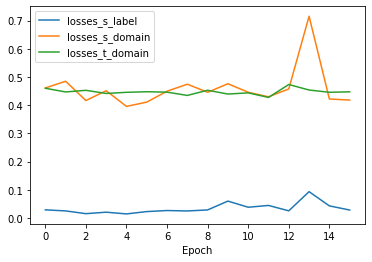

[1/16] class_loss: 0.0233 s_domain_loss: 0.4125 t_domain_loss: 0.4588 aplha: 0.9993292997390673
[2/16] class_loss: 0.0481 s_domain_loss: 0.4179 t_domain_loss: 0.4476 aplha: 0.9993499283095266
[3/16] class_loss: 0.0213 s_domain_loss: 0.3957 t_domain_loss: 0.4550 aplha: 0.9993699226118375
[4/16] class_loss: 0.0231 s_domain_loss: 0.4435 t_domain_loss: 0.4434 aplha: 0.999389302135776
[5/16] class_loss: 0.0266 s_domain_loss: 0.4074 t_domain_loss: 0.4480 aplha: 0.9994080857729739
[6/16] class_loss: 0.0204 s_domain_loss: 0.4193 t_domain_loss: 0.4503 aplha: 0.999426291835225
[7/16] class_loss: 0.0439 s_domain_loss: 0.3923 t_domain_loss: 0.4492 aplha: 0.9994439380722449
[8/16] class_loss: 0.0263 s_domain_loss: 0.4424 t_domain_loss: 0.4383 aplha: 0.9994610416888825
[9/16] class_loss: 0.0301 s_domain_loss: 0.4390 t_domain_loss: 0.4560 aplha: 0.9994776193618087
[10/16] class_loss: 0.0252 s_domain_loss: 0.3964 t_domain_loss: 0.4409 aplha: 0.9994936872556979
[11/16] class_loss: 0.0492 s_domain_loss:

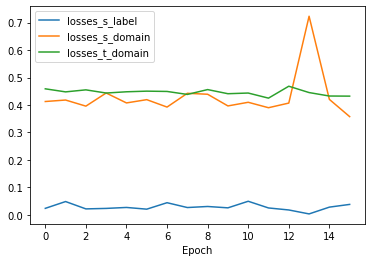

[1/16] class_loss: 0.0286 s_domain_loss: 0.4918 t_domain_loss: 0.4406 aplha: 0.9995931460438896
[2/16] class_loss: 0.0213 s_domain_loss: 0.4029 t_domain_loss: 0.4288 aplha: 0.9996056611560755
[3/16] class_loss: 0.0197 s_domain_loss: 0.4169 t_domain_loss: 0.4349 aplha: 0.9996177913682447
[4/16] class_loss: 0.0329 s_domain_loss: 0.4420 t_domain_loss: 0.4220 aplha: 0.9996295485134694
[5/16] class_loss: 0.0175 s_domain_loss: 0.3896 t_domain_loss: 0.4269 aplha: 0.9996409440613065
[6/16] class_loss: 0.0204 s_domain_loss: 0.3993 t_domain_loss: 0.4288 aplha: 0.9996519891289457
[7/16] class_loss: 0.0175 s_domain_loss: 0.3935 t_domain_loss: 0.4289 aplha: 0.9996626944920217
[8/16] class_loss: 0.0302 s_domain_loss: 0.4007 t_domain_loss: 0.4175 aplha: 0.9996730705950918
[9/16] class_loss: 0.0426 s_domain_loss: 0.3808 t_domain_loss: 0.4366 aplha: 0.999683127561795
[10/16] class_loss: 0.0156 s_domain_loss: 0.4027 t_domain_loss: 0.4203 aplha: 0.9996928752047007
[11/16] class_loss: 0.0254 s_domain_loss

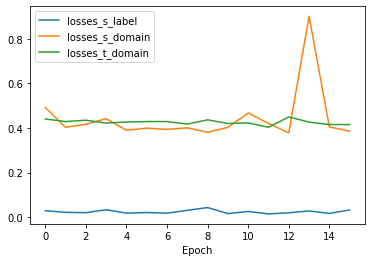

[1/16] class_loss: 0.0159 s_domain_loss: 0.3837 t_domain_loss: 0.4274 aplha: 0.9997532108480274
[2/16] class_loss: 0.0179 s_domain_loss: 0.3924 t_domain_loss: 0.4157 aplha: 0.9997608028438996
[3/16] class_loss: 0.0153 s_domain_loss: 0.3728 t_domain_loss: 0.4226 aplha: 0.9997681613136271
[4/16] class_loss: 0.0282 s_domain_loss: 0.3666 t_domain_loss: 0.4085 aplha: 0.9997752934387225
[5/16] class_loss: 0.0125 s_domain_loss: 0.4396 t_domain_loss: 0.4125 aplha: 0.9997822061799468
[6/16] class_loss: 0.0291 s_domain_loss: 0.3871 t_domain_loss: 0.4151 aplha: 0.9997889062840914
[7/16] class_loss: 0.0335 s_domain_loss: 0.3869 t_domain_loss: 0.4146 aplha: 0.9997954002905483
[8/16] class_loss: 0.0199 s_domain_loss: 0.3713 t_domain_loss: 0.4034 aplha: 0.9998016945376818
[9/16] class_loss: 0.0217 s_domain_loss: 0.3628 t_domain_loss: 0.4228 aplha: 0.999807795169001
[10/16] class_loss: 0.0124 s_domain_loss: 0.3857 t_domain_loss: 0.4064 aplha: 0.9998137081391485
[11/16] class_loss: 0.0191 s_domain_loss

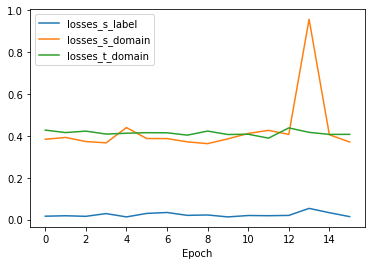

[1/16] class_loss: 0.0190 s_domain_loss: 0.3585 t_domain_loss: 0.4232 aplha: 0.999850307544979
[2/16] class_loss: 0.0164 s_domain_loss: 0.3646 t_domain_loss: 0.4111 aplha: 0.9998549127635394
[3/16] class_loss: 0.0226 s_domain_loss: 0.3810 t_domain_loss: 0.4176 aplha: 0.9998593763146617
[4/16] class_loss: 0.0190 s_domain_loss: 0.3886 t_domain_loss: 0.4015 aplha: 0.9998637025557675
[5/16] class_loss: 0.0230 s_domain_loss: 0.3832 t_domain_loss: 0.4068 aplha: 0.9998678957102909
[6/16] class_loss: 0.0174 s_domain_loss: 0.3928 t_domain_loss: 0.4102 aplha: 0.9998719598717924
[7/16] class_loss: 0.0167 s_domain_loss: 0.3497 t_domain_loss: 0.4107 aplha: 0.9998758990079541
[8/16] class_loss: 0.0251 s_domain_loss: 0.4177 t_domain_loss: 0.3999 aplha: 0.9998797169644462
[9/16] class_loss: 0.0252 s_domain_loss: 0.3739 t_domain_loss: 0.4213 aplha: 0.9998834174686777
[10/16] class_loss: 0.0346 s_domain_loss: 0.3953 t_domain_loss: 0.4064 aplha: 0.9998870041334327
[11/16] class_loss: 0.0137 s_domain_loss

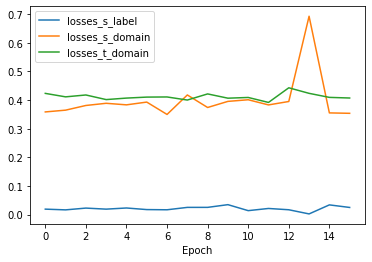

In [21]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime
running_corrects = 0
current_step = 0
# Start iterating over the epochs
# Iterate over the dataset

for epoch in range(NUM_EPOCHS):
  scheduler.step() 
  iterPh = iter(photos_dataloader)
  iterAP = iter(art_painting_dataloader)
  losses = []
  for batch in range(max_batches):
    net.train() # Sets module in training mode
    optimizer.zero_grad() # Zero-ing the gradients
    if( batch == min_batches):
      iterPh = iter(photos_dataloader)
    images_source, labels_source = next(iterPh)
    labels_domain = torch.zeros(len(images_source), dtype=torch.long)

    p = float(batch + epoch * max_batches) / (NUM_EPOCHS * max_batches)
    alfa = 2. / (1. + np.exp(-10 * p)) - 1
    
    # Bring data over the device of choice
    images_source = images_source.to(DEVICE)
    labels_source = labels_source.to(DEVICE)
    labels_domain = labels_domain.to(DEVICE)

  
    # Get the output for classes and domains; class_pred, domain_pred
    classes_output = net(images_source)
    # Compute the loss on the source domain
    loss_s_label = criterion_class(classes_output, labels_source)

    domain_output = net(images_source, alfa)
    # Compute the loss on the source domain
    loss_s_domain = criterion_domain(domain_output, labels_domain)

    # Get the output for targets
    targets, _ = next(iterAP)
    target_domain = torch.ones(len(targets), dtype=torch.long)

    # Bring data over the device of choice
    targets = targets.to(DEVICE)
    target_domain = target_domain.to(DEVICE)

    target_output = net(targets, alfa)
    # Compute the loss on the source domain
    loss_t_domain = criterion_domain(target_output,target_domain)

    loss = loss_s_label + loss_s_domain + loss_t_domain
    loss.backward()  # backward pass: computes gradients
    losses.append( (loss_s_label, loss_s_domain, loss_t_domain))
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

    print(f'[{batch+1}/{max_batches}] '
          f'class_loss: {loss_s_label.item():.4f} ' f's_domain_loss: {loss_s_domain.item():.4f} '
          f't_domain_loss: {loss_t_domain.item():.4f} '
          f'aplha: {alfa}'
          )  
  torch.save(net, 'model_epoch_{0}.pt'.format(epoch))
  testFunction('photo', epoch)
  testFunction('artPainting', epoch)
  plotfunction(losses)
  

In [20]:
LR

1e-05

In [21]:
alfa

0.1